# STM Transit Delay Data Modeling

## Overview

This notebook explores tree-based machine learning models in order to find the one that predicts STM transit delays with the best accuracy. The featured models are XGBoost, LightGBM and CatBoost, because they are more suitable for large datasets with mixed data and high cardinality.

## Imports

In [1]:
from catboost import CatBoostRegressor
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns
import shap
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
import sys
import xgboost as xgb

In [2]:
# Import custom code
sys.path.insert(0, '..')
from src.helper_functions import get_top_abs_correlations

In [3]:
# Load data
df = pd.read_parquet('../data/preprocessed.parquet')
print(f'Shape of dataset: {df.shape}')

Shape of dataset: (3765446, 22)


## Split the data

Due to the large volume of data, the dataset will be sampled for faster experimentation. In order to keep the distribution, stratified sampling based on quantiles of the target variable will be applied.

In [4]:
# Define quantiles for stratification
df['delay_quantile'] = pd.qcut(df['delay'], q=10, labels=False, duplicates='drop')
df['delay_quantile'].value_counts()

delay_quantile
0    2814356
2     376583
3     376393
1     198114
Name: count, dtype: int64

In [5]:
# Train-test split (80-20)
df_train, df_temp = train_test_split(
  df,
  test_size=0.2,
  stratify=df['delay_quantile'],
  random_state=42
)

In [6]:
# Sample train set (25% of the full train set)
df_train_sample, _ = train_test_split(
  df_train,
  train_size=0.25,
  stratify=df_train['delay_quantile'],
  random_state=42
)

The 3 selected models can run multiple iterations with a training and validation set. Therefore, a hold-out set will be kept to evaluate the final model.

In [7]:
# Separate validation and test set
df_val, df_test = train_test_split(
  df_temp,
  test_size=0.5,
  stratify=df_temp['delay_quantile'],
  random_state=42
)
del df_temp

In [8]:
# Make sure the quantile distribution is preserved
print(df['delay_quantile'].value_counts(normalize=True))
print(df_train['delay_quantile'].value_counts(normalize=True))
print(df_train_sample['delay_quantile'].value_counts(normalize=True))
print(df_val['delay_quantile'].value_counts(normalize=True))
print(df_test['delay_quantile'].value_counts(normalize=True))

delay_quantile
0    0.747416
2    0.100010
3    0.099960
1    0.052614
Name: proportion, dtype: float64
delay_quantile
0    0.747416
2    0.100010
3    0.099960
1    0.052614
Name: proportion, dtype: float64
delay_quantile
0    0.747416
2    0.100009
3    0.099960
1    0.052614
Name: proportion, dtype: float64
delay_quantile
0    0.747417
2    0.100012
3    0.099959
1    0.052613
Name: proportion, dtype: float64
delay_quantile
0    0.747417
2    0.100009
3    0.099959
1    0.052615
Name: proportion, dtype: float64


In [9]:
# Drop delay_quantile
df = df.drop('delay_quantile', axis=1)
df_train = df_train.drop('delay_quantile', axis=1)
df_train_sample = df_train_sample.drop('delay_quantile', axis=1)
df_val = df_val.drop('delay_quantile', axis=1)
df_test = df_test.drop('delay_quantile', axis=1)

In [10]:
# Separate features from target variable
target = 'delay'
feature_cols = [col for col in df.columns if col != target]

X = df[feature_cols]
X_train = df_train[feature_cols]
X_train_sample = df_train_sample[feature_cols]
X_val = df_val[feature_cols]
X_test = df_test[feature_cols]

y = df[target]
y_train = df_train[target]
y_train_sample = df_train_sample[target]
y_val = df_val[target]
y_test = df_test[target]

del feature_cols
del target
del df_train
del df_train_sample
del df_val
del df_test

**Scaling**

Since only tree-based models are explored in this project, **scaling is not needed** because the models are not sensitive to the absolute scale or distribution of the features.

## Fit Base Models

All models allow to setup a number of rounds and early stopping. To start, all models will run 100 rounds with an early stopping of 3.

In [11]:
# Create dataframe to track metrics
metrics_df = pd.DataFrame(columns=['model', 'MAE', 'RMSE', 'R²'])

In [12]:
def add_metrics(metrics_df:pd.DataFrame, y_pred:pd.Series, y_true:pd.Series, model_name:str) -> pd.DataFrame:
	mae = mean_absolute_error(y_true, y_pred)
	rmse = root_mean_squared_error(y_true, y_pred)
	r2 = r2_score(y_true, y_pred)

	metrics_df.loc[len(metrics_df)] = [model_name, mae, rmse, r2]
	return metrics_df

### XGBoost

In [13]:
# Create regression matrices
xg_train_data = xgb.DMatrix(X_train_sample, y_train_sample, enable_categorical=False)
xg_val_data = xgb.DMatrix(X_val, y_val, enable_categorical=False)
xg_eval_set = [(xg_train_data, 'train'), (xg_val_data, 'validation')]

In [14]:
# Train model
xg_reg_base = xgb.train(
  params= {'objective': 'reg:squarederror', 'tree_method': 'hist'},
  dtrain=xg_train_data,
  num_boost_round=100,
  evals=xg_eval_set,
  verbose_eval=10,
  early_stopping_rounds=3,
)

[0]	train-rmse:152.17145	validation-rmse:151.69917
[10]	train-rmse:146.65817	validation-rmse:146.56843
[20]	train-rmse:145.09127	validation-rmse:145.26306
[30]	train-rmse:143.18516	validation-rmse:143.73375
[40]	train-rmse:141.85074	validation-rmse:142.56636
[50]	train-rmse:140.62315	validation-rmse:141.70527
[60]	train-rmse:139.28168	validation-rmse:140.82393
[70]	train-rmse:138.45214	validation-rmse:140.24414
[80]	train-rmse:137.36366	validation-rmse:139.48685
[90]	train-rmse:136.71970	validation-rmse:139.11949
[99]	train-rmse:135.87812	validation-rmse:138.64858


In [15]:
# Evaluate model
y_pred = xg_reg_base.predict(xg_val_data)

metrics_df = add_metrics(metrics_df, y_pred, y_val, 'xg_reg_base')
metrics_df

,model,MAE,RMSE,R²
0,xg_reg_base,71.402693,138.648576,0.195865


**MAE**<br>
On average, the predictions are off by 71 seconds, which is reasonable, knowing that [STM](https://www.stm.info/en/info/networks/bus-network-and-schedules-enlightened) considers a bus arriving 3 minutes after the planned schedule as being on time.

**RMSE**<br>
The higher RMSE compared to MAE suggests that there are some significant prediction errors that influence the overall error metric.

**R²**<br>
The model explains 19.6% of the variance, which is not very good.

### LightGBM

In [16]:
# Create regression datasets
lgb_train_data = lgb.Dataset(X_train_sample, label=y_train_sample)
lgb_val_data = lgb.Dataset(X_val, label=y_val, reference=lgb_train_data)

In [17]:
# Train model
lgb_reg_base = lgb.train(
    params={
        'objective': 'regression',
        'metric': 'rmse',
        'learning_rate': 0.05,
        'max_depth': -1
    },
    train_set=lgb_train_data,
    valid_sets=[lgb_val_data],
    num_boost_round=100,
    callbacks=[lgb.early_stopping(stopping_rounds=3)]
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.118327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1691
[LightGBM] [Info] Number of data points in the train set: 753089, number of used features: 21
[LightGBM] [Info] Start training from score 51.719471
Training until validation scores don't improve for 3 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's rmse: 145.224


In [18]:
# Evaluate model
y_pred = lgb_reg_base.predict(X_val)

metrics_df = add_metrics(metrics_df, y_pred, y_val, 'lgb_reg_base')
metrics_df

,model,MAE,RMSE,R²
0,xg_reg_base,71.402693,138.648576,0.195865
1,lgb_reg_base,74.150983,145.223564,0.117790


The baseline LightGBM model performs worse than XGBoost.

### CatBoost

In [19]:
# Fit model
cat_reg_base = CatBoostRegressor(
    iterations=100,
    learning_rate=0.05,
    depth=10,
    random_seed=42,
    verbose=10
)

cat_reg_base.fit(X_train_sample, y_train_sample, eval_set=(X_val, y_val), early_stopping_rounds=3)

0:	learn: 154.7740938	test: 154.1182865	best: 154.1182865 (0)	total: 251ms	remaining: 24.8s
10:	learn: 151.4457733	test: 150.8642820	best: 150.8642820 (10)	total: 1.51s	remaining: 12.2s
20:	learn: 149.7969896	test: 149.3000691	best: 149.3000691 (20)	total: 2.59s	remaining: 9.76s
30:	learn: 148.8360345	test: 148.4275635	best: 148.4275635 (30)	total: 3.64s	remaining: 8.11s
40:	learn: 148.2215513	test: 147.8765908	best: 147.8765908 (40)	total: 4.71s	remaining: 6.78s
50:	learn: 147.7132328	test: 147.4400360	best: 147.4400360 (50)	total: 5.8s	remaining: 5.58s
60:	learn: 147.3356066	test: 147.1325389	best: 147.1325389 (60)	total: 6.91s	remaining: 4.42s
70:	learn: 146.9723211	test: 146.8274508	best: 146.8274508 (70)	total: 8.01s	remaining: 3.27s
80:	learn: 146.6204728	test: 146.5257018	best: 146.5257018 (80)	total: 9.33s	remaining: 2.19s
90:	learn: 146.3206902	test: 146.2387025	best: 146.2387025 (90)	total: 10.5s	remaining: 1.04s
99:	learn: 146.0292994	test: 145.9870577	best: 145.9870577 (99)

In [20]:
# Evaluate model
y_pred = cat_reg_base.predict(X_val)

metrics_df = add_metrics(metrics_df, y_pred, y_val, 'cat_reg_base')
metrics_df

,model,MAE,RMSE,R²
0,xg_reg_base,71.402693,138.648576,0.195865
1,lgb_reg_base,74.150983,145.223564,0.117790
2,cat_reg_base,74.216114,145.987058,0.108489


CatBoost performs almost like LightGBM. Without tuning, XGBoost seems to capture more of the underlying patterns than the two other models.

## Hyperparameter Tuning

For all three models, a Randomized Search with 2-Fold Cross-Validation will be performed instead of a Grid Search, to save computation time.

### XGBoost

In [21]:
param_dist = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'alpha': [0, 1, 2, 3, 4, 5],
    'lambda': [0, 1, 2, 3, 4, 5]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100, verbosity=0)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    scoring='neg_root_mean_squared_error',
    cv=2,
    verbose=1,
    n_iter=50,
    random_state=42
)

random_search.fit(X_train_sample, y_train_sample)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


RandomizedSearchCV(cv=2,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=100,
                                          n_jobs=None, num_parallel_tree=None, ...),
                   n_iter=50,
                   param_distributions={'alpha': [0, 1, 2, 3, 4, 5],
                                        'colsample_bytree': [0.6, 0.8, 1.0],
                                        'lambda': [0, 1, 2, 3, 4, 5],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [22]:
# Best model
xg_reg_tuned = random_search.best_estimator_
xg_best_params = random_search.best_params_

In [23]:
# Evaluate model
y_pred = xg_reg_tuned.predict(X_val)

metrics_df = add_metrics(metrics_df, y_pred, y_val, 'xg_reg_tuned')
metrics_df

,model,MAE,RMSE,R²
0,xg_reg_base,71.402693,138.648576,0.195865
1,lgb_reg_base,74.150983,145.223564,0.117790
2,cat_reg_base,74.216114,145.987058,0.108489
3,xg_reg_tuned,70.972929,138.247486,0.200511


The performance of the tuned XGBoost model didn't improve much from the base model.

### LightGBM

In [25]:
param_dist = {
  'learning_rate': [0.01, 0.05, 0.1],
  'max_depth': [5, 10, 15],
  'num_leaves': [20, 31, 40],
  'min_child_samples': [10, 20, 30],
  'subsample': [0.8, 1.0],
  'colsample_bytree': [0.8, 1.0],
  'reg_alpha': [0, 1, 2, 3, 4, 5],
  'reg_lambda': [0, 1, 2, 3, 4, 5],
}

lgb_model = lgb.LGBMRegressor(random_state=42, verbosity=0, n_estimators=100)

random_search = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist,
    n_iter=50,
    cv=2, 
    scoring='neg_root_mean_squared_error',
    verbose=1,
    random_state=42
)

random_search.fit(X_train_sample, y_train_sample)

Fitting 2 folds for each of 50 candidates, totalling 100 fits
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits

RandomizedSearchCV(cv=2, estimator=LGBMRegressor(random_state=42, verbosity=0),
                   n_iter=50,
                   param_distributions={'colsample_bytree': [0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [5, 10, 15],
                                        'min_child_samples': [10, 20, 30],
                                        'num_leaves': [20, 31, 40],
                                        'reg_alpha': [0, 1, 2, 3, 4, 5],
                                        'reg_lambda': [0, 1, 2, 3, 4, 5],
                                        'subsample': [0.8, 1.0]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [26]:
# Best model
lgb_reg_tuned = random_search.best_estimator_
lgb_best_params = random_search.best_params_

In [27]:
# Evaluate model
y_pred = lgb_reg_tuned.predict(X_val)

reg_metrics_df = add_metrics(metrics_df, y_pred, y_val, 'lgb_reg_tuned')
reg_metrics_df

,model,MAE,RMSE,R²
0,xg_reg_base,71.402693,138.648576,0.195865
1,lgb_reg_base,74.150983,145.223564,0.117790
2,cat_reg_base,74.216114,145.987058,0.108489
3,xg_reg_tuned,70.972929,138.247486,0.200511
4,lgb_reg_tuned,72.849016,141.806285,0.158820


There's a slight improvement from the baseline model but it doesn't perform as good as XGBoost.

### CatBoost

In [29]:
param_dist = {
  'learning_rate': [0.01, 0.05, 0.1],
  'depth': [6, 8, 10],
  'l2_leaf_reg': [0, 1, 2, 3, 4, 5],
  'border_count': [32, 64, 128],
  'bagging_temperature': [0, 1, 5],
}

cat_model = CatBoostRegressor(verbose=0, random_seed=42, n_estimators=100)

random_search = RandomizedSearchCV(
    estimator=cat_model,
    param_distributions=param_dist,
    n_iter=50,
    cv=2,
    scoring='neg_root_mean_squared_error',
    verbose=1,
    random_state=42
)

random_search.fit(X_train_sample, y_train_sample)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


RandomizedSearchCV(cv=2,
                   estimator=<catboost.core.CatBoostRegressor object at 0x12ab19e20>,
                   n_iter=50,
                   param_distributions={'bagging_temperature': [0, 1, 5],
                                        'border_count': [32, 64, 128],
                                        'depth': [6, 8, 10],
                                        'l2_leaf_reg': [0, 1, 2, 3, 4, 5],
                                        'learning_rate': [0.01, 0.05, 0.1]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [30]:
# Best model
cat_reg_tuned = random_search.best_estimator_
cat_best_params = random_search.best_params_

In [31]:
# Evaluate model
y_pred = cat_reg_tuned.predict(X_val)

reg_metrics_df = add_metrics(reg_metrics_df, y_pred, y_val, 'cat_reg_tuned')
reg_metrics_df

,model,MAE,RMSE,R²
0,xg_reg_base,71.402693,138.648576,0.195865
1,lgb_reg_base,74.150983,145.223564,0.117790
2,cat_reg_base,74.216114,145.987058,0.108489
3,xg_reg_tuned,70.972929,138.247486,0.200511
4,lgb_reg_tuned,72.849016,141.806285,0.158820
5,cat_reg_tuned,73.012042,144.019972,0.132352


The tuned model performs better than the baseline CatBoost but not as good as the tuned XGBoost. The latter will be used for the rest of the analysis.

## Residual Analysis

In [32]:
def plot_residuals(y_true, y_pred, model_name:str) -> None:
	fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

	# Predicted vs. actual values
	ax1.scatter(x=y_pred, y=y_true)
	ax1.set_title('Predicted vs. Actual values')
	ax1.set_xlabel('Predicted Delay (seconds)')
	ax1.set_ylabel('Actual Delay (seconds)')
	ax1.grid(True)

	# Residuals
	residuals = y_true - y_pred
	ax2.scatter(x=y_pred, y=residuals)
	ax2.set_title('Residual Plot')
	ax2.set_xlabel('Predicted Delay (seconds)')
	ax2.set_ylabel('Residuals (seconds)')
	ax2.axhline(0, linestyle='--', color='orange')
	ax2.grid(True)

	fig.suptitle('Residual Analysis', fontsize=18)
	fig.tight_layout()
	fig.savefig(f'../images/residual_analysis_{model_name}.png', bbox_inches='tight')
	plt.show()

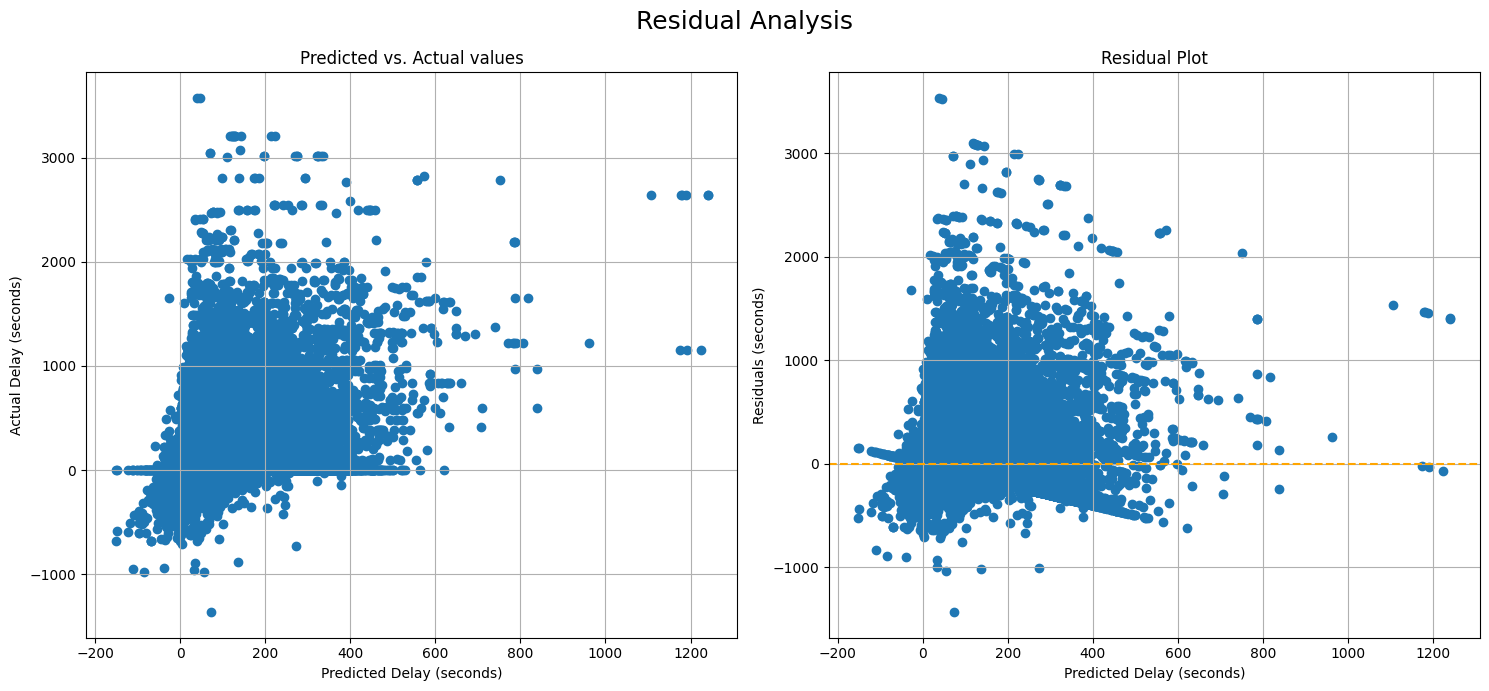

In [33]:
# Plot residuals
plot_residuals(y_val, y_pred, 'xg_reg_tuned')

**Predicted vs. Actual Plot**

There is a large cluster of points concentrated between 0 and 400 seconds for predicted values, but the actual values are far more dispersed, reaching well over 3000 seconds. Extreme positive delays (up to 3000 seconds) are under-predicted. A few strong negative delays are also under-predicted. The spread is asymmetric, indicating that the model struggles more with predicting large delays than smaller ones.There's a clear horizontal line at 0 for actual delay, which might indicate some trips are reported as perfectly on time, but the model is not capturing the subtle variations well.


**Residual Plot**

The residuals are not randomly scattered. There is a clear funnel shape, where the variance increases as predicted delays grow. This is a sign of heteroscedasticity, meaning the error magnitude increases with larger predictions. Many points are concentrated in a dense vertical stripe, indicating that a large number of predictions are in a narrow range (0-200 seconds), but the real-world delay is much more spread out. There are clusters of residuals above 1000 seconds—this shows the model is systematically underestimating large delays.

## Feature Importances

In [34]:
# Get top 5 most important features
importances = xg_reg_tuned.get_booster().get_score()
importances_df = pd.DataFrame.from_dict(importances, orient='index') \
	.rename(columns={0: 'importance'}).reset_index() \
	.rename(columns={'index': 'feature'})
importances_df.sort_values('importance', ascending=False).head()

,feature,importance
2,exp_trip_duration,1699.0
3,hist_avg_delay,1580.0
9,route_bearing,1451.0
0,arrivals_per_hour,901.0
17,trip_progress,785.0


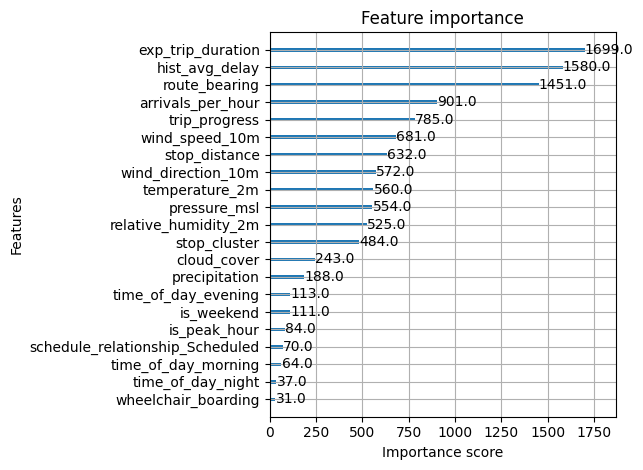

In [62]:
# Plot the feature importances
ax = xgb.plot_importance(xg_reg_tuned)
ax.figure.tight_layout()
ax.figure.savefig('../images/feature_importances_xg_reg_tuned.png', bbox_inches='tight')
plt.show()

**Most Important Features:**
- `exp_trip_duration` This is the most important feature in the model. It seems like the expected trip duration is highly predictive of the actual delay. This makes sense as longer expected trips are more prone to disruptions and variations.
- `hist_avg_delay` Historical average delay is the second most important predictor. This aligns well with time series predictability since past delays often indicate patterns or bottlenecks that repeat over time.
- `route_bearing` The direction of a vehicle might indicate if it's in the direction of traffic or not.
- `arrivals_per_hour` The bus frequency is contributing to the prediction. Less frequent buses might be more susceptible to delays since missed connections or unexpected traffic issues tend to accumulate.
- `trip_progress` Delays accumulate when the vehicle is further along the trip.


**Least Important Features:**
- `is_peak_hour` This is less impactful than expected. It suggests that perhaps peak hours are not as unpredictable as other features.
- `schedule_relationship_Scheduled` This has low impact, which might indicate that deviations from scheduled times are not systematically captured by the model.
- `time_of_day_morning`, `time_of_day_night` Evening seems to be a bit more influential than morning or night, which could indicate evening rush hour impacts.
- `wheelchair_boarding` Very low importance, indicating it has minimal influence on delays.


## SHAP Plots

In [36]:
def shap_plot(shap_values, X_true, model_name:str, barplot:bool=True) -> None:
	if barplot:
		shap.summary_plot(shap_values, X_true, plot_type='bar', show=False)
		plt.title('SHAP Summary Barplot')
		plot_type = 'barplot' 
	else: # beeswarm
		shap.summary_plot(shap_values, X_true, show=False)
		plt.title('SHAP Summary Beeswarm Plot')
		plot_type = 'beeswarm_plot' 
	plt.tight_layout()
	plt.savefig(f'../images/shap_{plot_type}_{model_name}.png', bbox_inches='tight')
	plt.show()

In [37]:
def shap_single_pred(X_true, explainer, shap_values, model_name:str) -> None:
	random.seed(42)
	index = random.randrange(len(X_true))
	shap.force_plot(
		explainer.expected_value,
		shap_values[index, :],
		X_true.iloc[index, :],
		figsize=(55, 4),
		matplotlib=True,
		show=False)
	plt.tight_layout()
	plt.savefig(f'../images/shap_force_plot_{model_name}.png', bbox_inches='tight')
	plt.show()

In [38]:
# Initialize SHAP
X_val_sample = X_val.sample(25000, random_state=42) # sample validation set to prevent memory overload
explainer = shap.TreeExplainer(xg_reg_tuned)
shap_values = explainer.shap_values(X_val_sample)

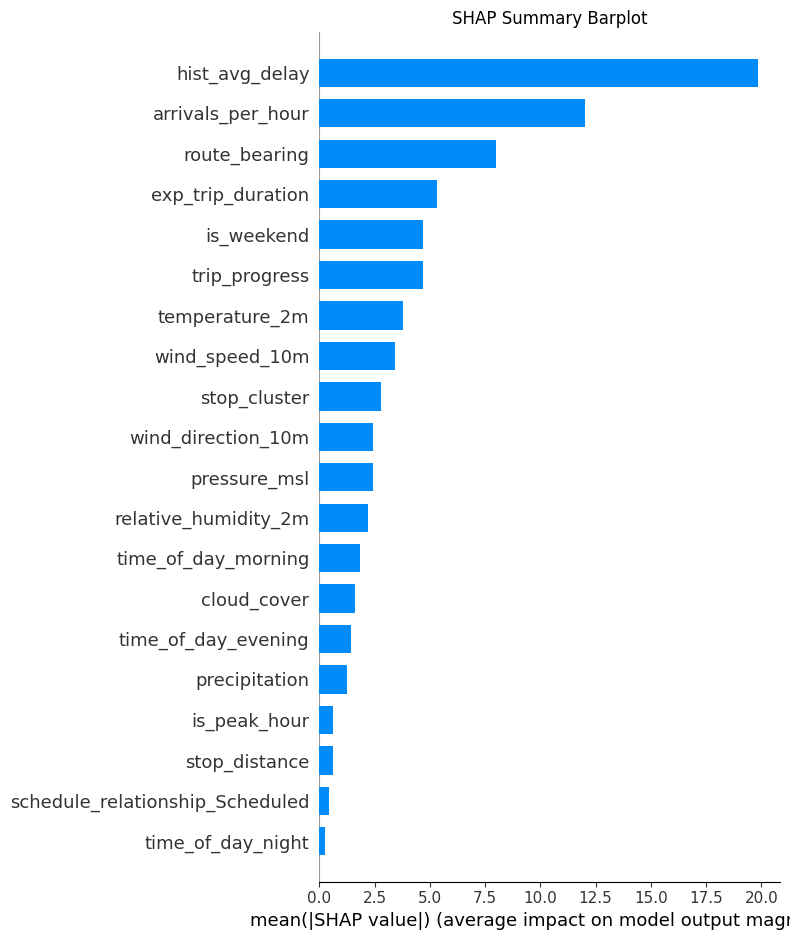

In [39]:
# Summary barplot
shap_plot(shap_values, X_val_sample, 'xg_reg_tuned', barplot=True)

**Comparison with XGBoost feature importances**

- Interestingly, `hist_avg_delay` comes out as the most impactful in this plot, while it was second in the XGBoost importance plot.
- `arrivals_per_hour` is elevated to the second position, while in the default importance, it is in fourth place.
- This suggests that in terms of predictive influence, `hist_avg_delay` and `arrivals_per_hour` are actually more significant than what the XGBoost default metric captured.

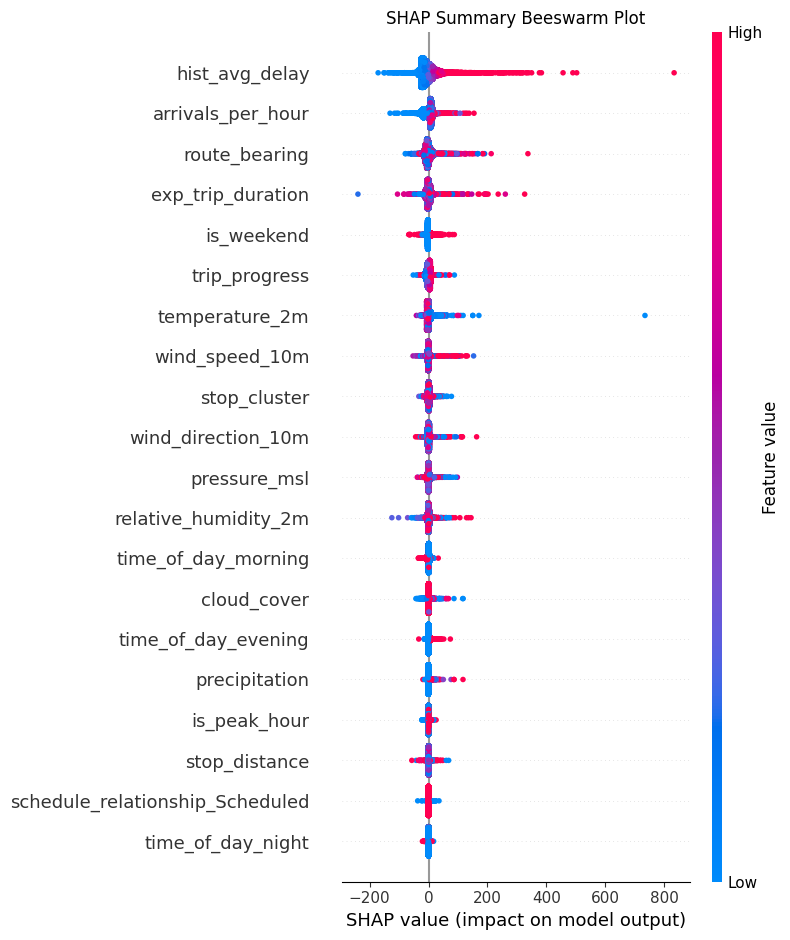

In [40]:
# Summary beeswarm plot
shap_plot(shap_values, X_val_sample, 'xg_reg_tuned', barplot=False)

**Interpretation**

- High `hist_avg_delay` (red) tends to push predictions higher, and low values (blue) push it lower. The high influence of `hist_avg_delay` confirms that delay is highly dependent on past performance. This could be useful for forecasting in specific segments or optimizing bus routes during peak times.
- Some features like `route_bearing` and `exp_trip_duration` and `is_weekend` have either a positive or negative infuence, suggesting there's a more complex feature interaction.

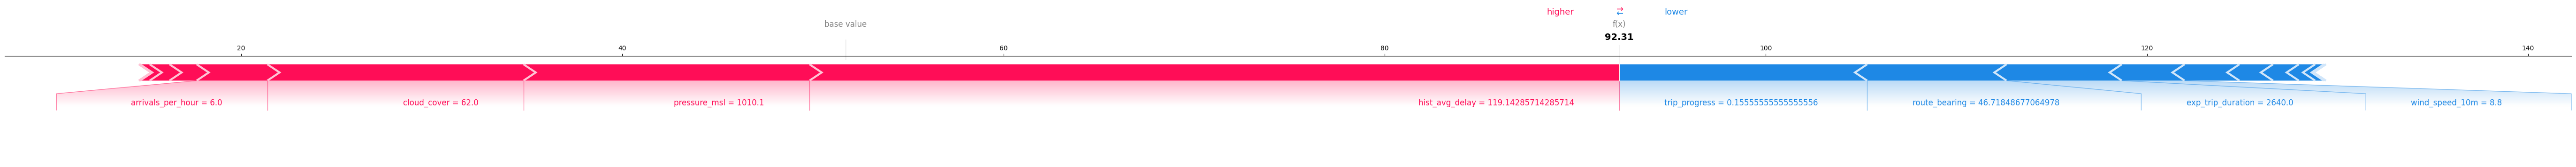

In [41]:
# Force plot a single prediction
shap_single_pred(X_val_sample, explainer, shap_values, 'xg_reg_tuned')

This plot is a breakdown of the specific prediction (`92.31`) for one instance.

- Features that increase the prediction (red):
	1. `hist_avg_delay` = `119.14`: This is the historical average delay, and it's having the largest upward influence on the prediction.
	2. `pressure_msl` = `1010.1`: Higher pressure seems to be associated with an increase in delay for this instance.
	3. `cloud_cover` = `62.0`: Cloud cover at this value is slightly contributing to the upward delay.
	4. `arrivals_per_hour` = `6.0`: A busier schedule (6 buses per hour) is also pushing the delay upward, although its influence is not as strong as historical average delay.

- Features that decrease the prediction (blue):
	1. `trip_progress` = `0.155`: The bus is still early in its trip (15.5% progress), which seems to correlate with reducing the predicted delay.
	2. `route_bearing` = `46.7`: The direction of the bus (North-East) has a small negative influence on the predicted delay.
	3. `exp_trip_duration` = `2640.0`: A relatively longer expected trip duration (44 minutes) is slightly pulling the prediction downward.
	4. `wind_speed_10m` = `8.8`: Wind speed is also slightly decreasing the prediction.

## Feature Optimization

### Add feature interactions

Some features were surprisingly low impact and the SHAP plots suggest there might be interactions between some features.

In [42]:
# Generate second degree polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)

X_poly = poly.fit_transform(X)
X_train_poly = poly.transform(X_train)
X_train_sample_poly = poly.transform(X_train_sample)
X_val_poly = poly.transform(X_val)
X_test_poly = poly.transform(X_test)

feature_names = poly.get_feature_names_out(X.columns)
X_poly = pd.DataFrame(X_poly, columns=feature_names)
X_train_poly = pd.DataFrame(X_train_poly, columns=feature_names)
X_train_sample_poly = pd.DataFrame(X_train_sample_poly, columns=feature_names)
X_val_poly = pd.DataFrame(X_val_poly, columns=feature_names)
X_test_poly = pd.DataFrame(X_test_poly, columns=feature_names)

X_poly.shape

(3765446, 231)

In [43]:
# Refit model
xg_reg_poly = xgb.XGBRegressor(
  	objective='reg:squarederror',
  	random_state=42,
  	n_estimators=100,
    max_depth=xg_best_params['max_depth'],
    learning_rate=xg_best_params['learning_rate'],
    subsample=xg_best_params['subsample'],
    colsample_bytree=xg_best_params['colsample_bytree'],
    alpha=xg_best_params['alpha'],
    reg_lambda=xg_best_params['lambda']
)

xg_reg_poly.fit(X_train_sample_poly, y_train_sample)

XGBRegressor(alpha=2, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, ...)

In [44]:
# Evaluate model
y_pred = xg_reg_poly.predict(X_val_poly)

metrics_df = add_metrics(metrics_df, y_pred, y_val, 'xg_reg_poly')
metrics_df

,model,MAE,RMSE,R²
0,xg_reg_base,71.402693,138.648576,0.195865
1,lgb_reg_base,74.150983,145.223564,0.117790
2,cat_reg_base,74.216114,145.987058,0.108489
3,xg_reg_tuned,70.972929,138.247486,0.200511
4,lgb_reg_tuned,72.849016,141.806285,0.158820
5,cat_reg_tuned,73.012042,144.019972,0.132352
6,xg_reg_poly,69.794693,135.429876,0.232768


There is a slight improvement from the tuned model without the polynomial features.

### Feature Elimination

In [45]:
# Apply Mutual Information to rank feature importance
mi_scores = mutual_info_regression(X_val_poly, y_val) # use validation set to save computation time

In [46]:
# Create dataframe
mi_df = pd.DataFrame({
    'feature': feature_names,
    'mi_score': mi_scores
}).sort_values(by='mi_score', ascending=False)
mi_df.head()

,feature,mi_score
141,pressure_msl route_bearing,0.474367
174,route_bearing wind_direction_10m,0.428477
168,route_bearing temperature_2m,0.423374
175,route_bearing wind_speed_10m,0.420130
66,exp_trip_duration route_bearing,0.418309


In [47]:
# Get most correlated features
correlations = get_top_abs_correlations(X_val_poly) # use validation set to save computation time
correlations

is_weekend                       is_weekend pressure_msl                               0.999997
precipitation                    precipitation pressure_msl                            0.999994
time_of_day_night                pressure_msl time_of_day_night                        0.999988
time_of_day_evening              pressure_msl time_of_day_evening                      0.999987
wind_direction_10m               pressure_msl wind_direction_10m                       0.999987
                                                                                         ...   
exp_trip_duration stop_distance  stop_distance temperature_2m                          0.900494
wind_speed_10m                   relative_humidity_2m wind_speed_10m                   0.900442
cloud_cover wind_direction_10m   schedule_relationship_Scheduled wind_direction_10m    0.900406
arrivals_per_hour                arrivals_per_hour temperature_2m                      0.900324
route_bearing                    route_b

In [48]:
# Get the features to drop
features_to_drop = list(set(correlations.index.get_level_values(level=1)))
features_to_drop

['relative_humidity_2m time_of_day_morning',
 'precipitation wheelchair_boarding',
 'cloud_cover is_weekend',
 'pressure_msl wind_direction_10m',
 'exp_trip_duration time_of_day_evening',
 'is_weekend pressure_msl',
 'pressure_msl time_of_day_evening',
 'wheelchair_boarding wind_direction_10m',
 'hist_avg_delay wheelchair_boarding',
 'precipitation schedule_relationship_Scheduled',
 'exp_trip_duration time_of_day_morning',
 'time_of_day_morning wheelchair_boarding',
 'precipitation wind_speed_10m',
 'route_bearing wheelchair_boarding',
 'relative_humidity_2m time_of_day_evening',
 'hist_avg_delay schedule_relationship_Scheduled',
 'schedule_relationship_Scheduled stop_distance',
 'exp_trip_duration stop_distance',
 'pressure_msl trip_progress',
 'pressure_msl schedule_relationship_Scheduled',
 'pressure_msl time_of_day_night',
 'is_peak_hour schedule_relationship_Scheduled',
 'is_peak_hour temperature_2m',
 'relative_humidity_2m trip_progress',
 'temperature_2m wind_direction_10m',
 'r

In [49]:
len(features_to_drop)

95

In [50]:
# Drop highly correlated features
X_best = X_poly.drop(features_to_drop, axis=1)
X_train_best = X_train_poly.drop(features_to_drop, axis=1)
X_train_sample_best = X_train_sample_poly.drop(features_to_drop, axis=1)
X_val_best = X_val_poly.drop(features_to_drop, axis=1)
X_test_best = X_test_poly.drop(features_to_drop, axis=1)

In [51]:
# Get Mutual Information Score of the remaining features
remaining_features = X_best.columns.tolist()
mi_df_filtered = mi_df[mi_df['feature'].isin(remaining_features)]
mi_df_filtered

,feature,mi_score
174,route_bearing wind_direction_10m,0.428477
168,route_bearing temperature_2m,0.423374
175,route_bearing wind_speed_10m,0.420130
66,exp_trip_duration route_bearing,0.418309
76,exp_trip_duration wind_direction_10m,0.305992
...,...,...
95,is_peak_hour is_weekend,0.000410
120,is_weekend time_of_day_morning,0.000000
210,time_of_day_evening time_of_day_morning,0.000000
211,time_of_day_evening time_of_day_night,0.000000


In [52]:
# Get top 25 features
best_features = mi_df_filtered.nlargest(n=25, columns='mi_score')['feature'].sort_values().tolist()
best_features

['arrivals_per_hour hist_avg_delay',
 'arrivals_per_hour route_bearing',
 'cloud_cover exp_trip_duration',
 'cloud_cover schedule_relationship_Scheduled',
 'exp_trip_duration relative_humidity_2m',
 'exp_trip_duration route_bearing',
 'exp_trip_duration schedule_relationship_Scheduled',
 'exp_trip_duration stop_cluster',
 'exp_trip_duration temperature_2m',
 'exp_trip_duration wind_direction_10m',
 'exp_trip_duration wind_speed_10m',
 'hist_avg_delay',
 'hist_avg_delay route_bearing',
 'hist_avg_delay stop_cluster',
 'hist_avg_delay wind_direction_10m',
 'hist_avg_delay wind_speed_10m',
 'relative_humidity_2m schedule_relationship_Scheduled',
 'route_bearing',
 'route_bearing stop_cluster',
 'route_bearing temperature_2m',
 'route_bearing wind_direction_10m',
 'route_bearing wind_speed_10m',
 'schedule_relationship_Scheduled temperature_2m',
 'stop_cluster temperature_2m',
 'stop_cluster wind_direction_10m']

In [53]:
# Keep best features in input matrices
X_best = X_poly[best_features]
X_train_best = X_train_poly[best_features]
X_train_sample_best = X_train_sample_poly[best_features]
X_val_best = X_val_poly[best_features]
X_test_best = X_test_poly[best_features]

## Retrain Model with Best Features

### Fit Model

In [54]:
# Refit model
xg_reg_pruned = xgb.XGBRegressor(
  	objective='reg:squarederror',
  	random_state=42,
  	n_estimators=100,
    max_depth=xg_best_params['max_depth'],
    learning_rate=xg_best_params['learning_rate'],
    subsample=xg_best_params['subsample'],
    colsample_bytree=xg_best_params['colsample_bytree'],
    alpha=xg_best_params['alpha'],
    reg_lambda=xg_best_params['lambda']
)

xg_reg_pruned.fit(X_train_sample_best, y_train_sample)

XGBRegressor(alpha=2, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.2, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, ...)

### Evaluate Model

In [55]:
y_pred = xg_reg_pruned.predict(X_val_best)

metrics_df = add_metrics(metrics_df, y_pred, y_val, 'xg_reg_pruned')
metrics_df

,model,MAE,RMSE,R²
0,xg_reg_base,71.402693,138.648576,0.195865
1,lgb_reg_base,74.150983,145.223564,0.117790
2,cat_reg_base,74.216114,145.987058,0.108489
3,xg_reg_tuned,70.972929,138.247486,0.200511
4,lgb_reg_tuned,72.849016,141.806285,0.158820
5,cat_reg_tuned,73.012042,144.019972,0.132352
6,xg_reg_poly,69.794693,135.429876,0.232768
7,xg_reg_pruned,70.325874,134.977752,0.237882


The RMSE and R-squared improved slightly after keeping the best polynomial features, which is good.

### Hyperparameter Tuning

In [56]:
param_dist = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'alpha': [0, 1, 2, 3, 4, 5],
    'lambda': [0, 1, 2, 3, 4, 5]
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    scoring='neg_root_mean_squared_error',
    cv=2,
    verbose=1,
    n_iter=50,
    random_state=42
)

random_search.fit(X_train_sample_best, y_train_sample)

Fitting 2 folds for each of 50 candidates, totalling 100 fits


RandomizedSearchCV(cv=2,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
                                          monotone_constraints=None,
                                          multi_strategy=None, n_estimators=100,
                                          n_jobs=None, num_parallel_tree=None, ...),
                   n_iter=50,
                   param_distributions={'alpha': [0, 1, 2, 3, 4, 5],
                                        'colsample_bytree': [0.6, 0.8, 1.0],
                                        'lambda': [0, 1, 2, 3, 4, 5],
                                        'learning_rate': [0.01, 0.1, 0.2],
                                        'max_depth': [3, 5, 7],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='neg_root_mean_squared_error',
                   verbose=1)

In [57]:
# Best model
xg_reg_pruned_tuned = random_search.best_estimator_
xg_best_params = random_search.best_params_

In [58]:
# Evaluate model
y_pred = xg_reg_pruned_tuned.predict(X_val_best)

metrics_df = add_metrics(metrics_df, y_pred, y_val, 'xg_reg_pruned_tuned')
metrics_df

,model,MAE,RMSE,R²
0,xg_reg_base,71.402693,138.648576,0.195865
1,lgb_reg_base,74.150983,145.223564,0.117790
2,cat_reg_base,74.216114,145.987058,0.108489
3,xg_reg_tuned,70.972929,138.247486,0.200511
4,lgb_reg_tuned,72.849016,141.806285,0.158820
5,cat_reg_tuned,73.012042,144.019972,0.132352
6,xg_reg_poly,69.794693,135.429876,0.232768
7,xg_reg_pruned,70.325874,134.977752,0.237882
8,xg_reg_pruned_tuned,70.325874,134.977752,0.237882


### Feature Importances

In [59]:
# Get top 5 most important features
importances = xg_reg_pruned_tuned.get_booster().get_score()
importances_df = pd.DataFrame.from_dict(importances, orient='index') \
	.rename(columns={0: 'importance'}).reset_index() \
	.rename(columns={'index': 'feature'})
importances_df.sort_values('importance', ascending=False).head()

,feature,importance
0,arrivals_per_hour hist_avg_delay,1026.0
1,arrivals_per_hour route_bearing,835.0
5,exp_trip_duration route_bearing,579.0
2,cloud_cover exp_trip_duration,553.0
8,exp_trip_duration temperature_2m,536.0


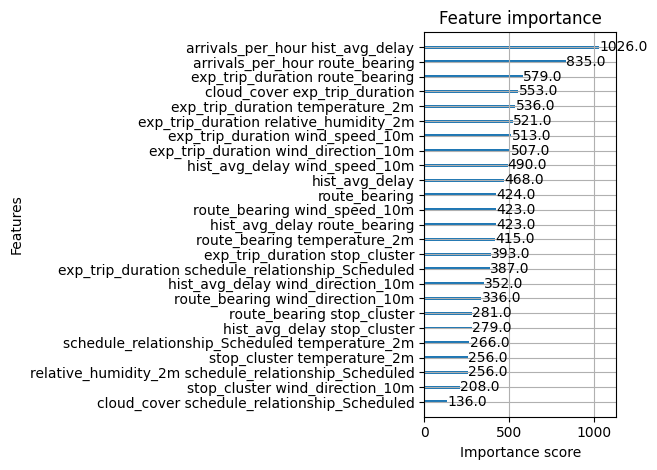

In [61]:
# Plot the feature importances
ax = xgb.plot_importance(xg_reg_pruned_tuned)
ax.figure.tight_layout()
ax.figure.savefig('../images/feature_importances_xg_reg_pruned_tuned.png', bbox_inches='tight')
plt.show()

- `arrivals_per_hour hist_avg_delay` and `arrivals_per_hour route_bearing` dominate the importance, suggesting that:
	- Congestion and historical delays are heavily influenced by how often buses arrive.
	- Certain route bearings are more problematic during heavy congestion.
- Weather interactions are prominent:
	- `cloud_cover exp_trip_duration`, `exp_trip_duration relative_humidity_2m`, and `exp_trip_duration temperature_2m` all rank highly, indicating that weather significantly interacts with travel duration.
- Interestingly, `schedule_relationship_Scheduled` now appears in interactions, suggesting a pattern based on the scheduled nature of the trips.

### SHAP Plots

In [63]:
# Initialize SHAP
sample_size = 25000 # sample test set to prevent memory overload
X_val_sample = X_val_best.sample(n=sample_size, random_state=42) 
explainer = shap.TreeExplainer(xg_reg_pruned)
shap_values = explainer.shap_values(X_val_sample)

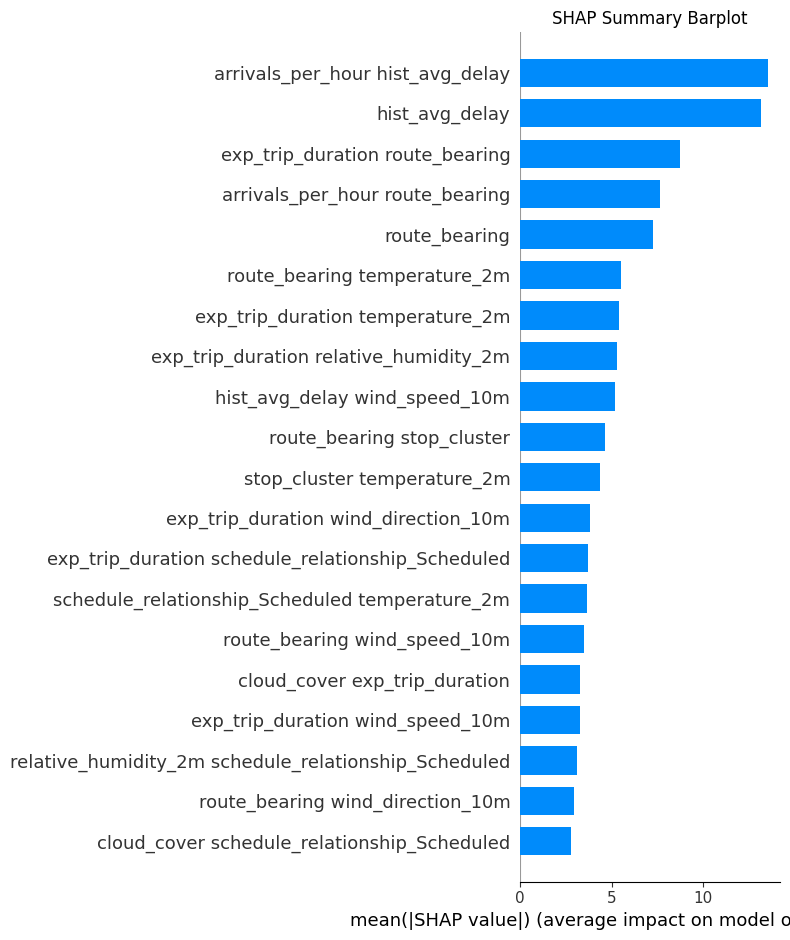

In [64]:
# Summary barplot
shap_plot(shap_values, X_val_sample, 'xg_reg_pruned_tuned', barplot=True)

- `hist_avg_delay` remains the top contributor, which is consistent with the XGBoost internal rankings.
- `arrivals_per_hour hist_avg_delay` is strongly influential, showing that when many buses arrive in historically delayed spots, it magnifies the delay prediction.
- `exp_trip_duration route_bearing` shows non-linear influence, hinting that the direction of travel matters more for longer trips.
- XGBoost's plot ranks `arrivals_per_hour route_bearing` slightly higher, while SHAP is more focused on `hist_avg_delay`.
- SHAP is picking up more on weather-based interactions than XGBoost, reflecting its sensitivity to impact rather than split frequency.

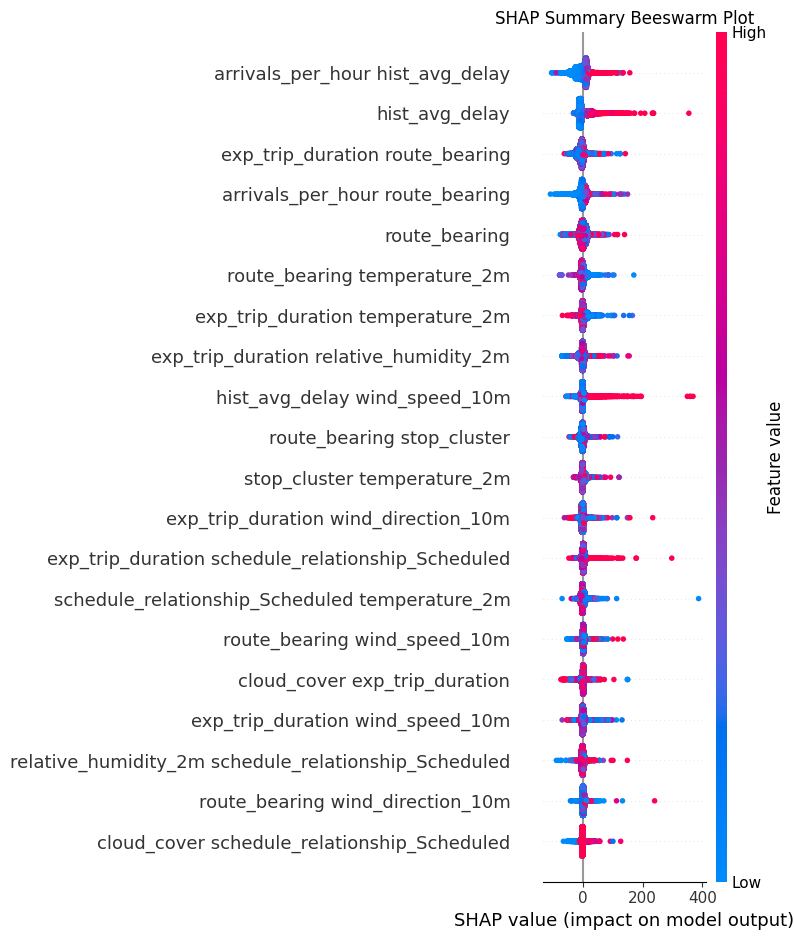

In [65]:
# Summary beeswarm plot
shap_plot(shap_values, X_val_sample, 'xg_reg_pruned_tuned', barplot=False)

- High `hist_avg_delay` (red) consistently pushes predictions up.
- `arrivals_per_hour hist_avg_delay` shows strong influence, with high values heavily pushing delays.
- Weather effects like `exp_trip_duration temperature_2m` and `exp_trip_duration wind_direction_10m` display clear influence, where extreme conditions amplify delays.
- Some features show threshold effects. For example, `route_bearing wind_direction_10m` spikes at certain wind directions, suggesting route sensitivity. `cloud_cover exp_trip_duration` also spikes under heavy cloud cover, reflecting weather impact.

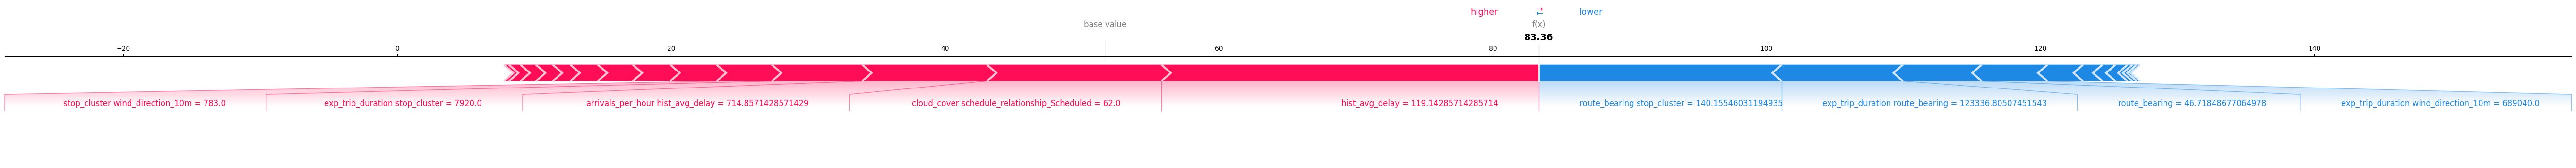

In [66]:
# Force plot a single prediction
shap_single_pred(X_val_sample, explainer, shap_values, 'xg_reg_pruned_tuned')

- `hist_avg_delay`, `cloud_cover schedule_relationship_Scheduled`, and `arrivals_per_hour hist_avg_delay` are the main drivers for higher delay.
- `route_bearing stop_cluster`, `exp_trip_duration route_bearing` and `route_bearing` somewhat mitigate the impact, but not enough to offset the upward push.

## Final Model

### Retrain Model

In [67]:
# Create regression matrices (full train set)
xg_train_data = xgb.DMatrix(X_train_best, y_train, enable_categorical=False)
xg_val_data = xgb.DMatrix(X_val_best, y_val, enable_categorical=False)
xg_test_data = xgb.DMatrix(X_test_best, y_test, enable_categorical=False)
xg_eval_set = [(xg_train_data, 'train'), (xg_val_data, 'validation')]

In [68]:
# Train final model with more boosting rounds
final_model = xgb.train(
  params= {
    'objective':'reg:squarederror', 
  	'tree_method': 'hist',
    'max_depth': xg_best_params['max_depth'],
    'learning_rate': xg_best_params['learning_rate'],
    'subsample': xg_best_params['subsample'],
    'colsample_bytree': xg_best_params['colsample_bytree'],
	'alpha': xg_best_params['alpha'],
    'lambda': xg_best_params['lambda'],
  },
  dtrain=xg_train_data,
  num_boost_round=10000,
  evals=xg_eval_set,
  verbose_eval=50,
  early_stopping_rounds=50
)

[0]	train-rmse:152.94585	validation-rmse:152.45116
[50]	train-rmse:137.80481	validation-rmse:138.04636
[100]	train-rmse:132.43146	validation-rmse:133.36257
[150]	train-rmse:128.48212	validation-rmse:130.02779
[200]	train-rmse:125.76304	validation-rmse:127.81101
[250]	train-rmse:123.67831	validation-rmse:126.11431
[300]	train-rmse:122.18006	validation-rmse:124.93262
[350]	train-rmse:120.80523	validation-rmse:123.88762
[400]	train-rmse:119.41959	validation-rmse:122.82803
[450]	train-rmse:118.36608	validation-rmse:122.09021
[500]	train-rmse:117.29120	validation-rmse:121.31589
[550]	train-rmse:116.44358	validation-rmse:120.69998
[600]	train-rmse:115.75917	validation-rmse:120.27040
[650]	train-rmse:114.97698	validation-rmse:119.73797
[700]	train-rmse:114.22961	validation-rmse:119.20652
[750]	train-rmse:113.57770	validation-rmse:118.78267
[800]	train-rmse:113.07292	validation-rmse:118.46675
[850]	train-rmse:112.57996	validation-rmse:118.20456
[900]	train-rmse:112.07938	validation-rmse:117.88

In [69]:
# Show best hyperparameters
xg_best_params

{'subsample': 1.0,
 'max_depth': 7,
 'learning_rate': 0.2,
 'lambda': 1,
 'colsample_bytree': 0.8,
 'alpha': 2}

### Evaluate with Test Set

In [70]:
# Evaluate model
y_pred = final_model.predict(xg_test_data)

metrics_df = add_metrics(metrics_df, y_pred, y_test, 'xg_reg_final')
metrics_df

,model,MAE,RMSE,R²
0,xg_reg_base,71.402693,138.648576,0.195865
1,lgb_reg_base,74.150983,145.223564,0.117790
2,cat_reg_base,74.216114,145.987058,0.108489
3,xg_reg_tuned,70.972929,138.247486,0.200511
4,lgb_reg_tuned,72.849016,141.806285,0.158820
5,cat_reg_tuned,73.012042,144.019972,0.132352
6,xg_reg_poly,69.794693,135.429876,0.232768
7,xg_reg_pruned,70.325874,134.977752,0.237882
8,xg_reg_pruned_tuned,70.325874,134.977752,0.237882
9,xg_reg_final,58.511841,115.445868,0.452087


Using the full train set dramatically improved the performance of the model.

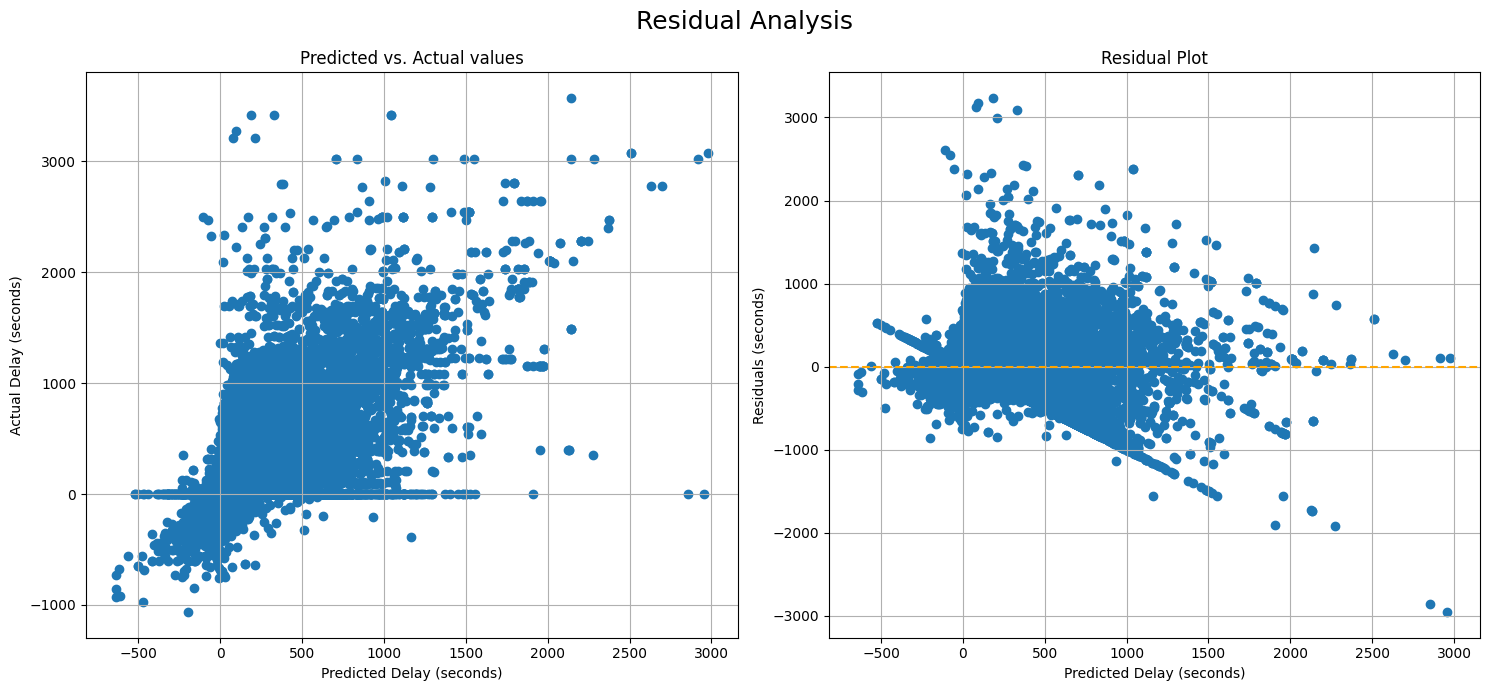

In [71]:
# Plot residuals
plot_residuals(y_test, y_pred, 'xg_reg_final')

### Make Prediction

In [72]:
# Display features
best_features = X_best.columns.tolist()
best_features

['arrivals_per_hour hist_avg_delay',
 'arrivals_per_hour route_bearing',
 'cloud_cover exp_trip_duration',
 'cloud_cover schedule_relationship_Scheduled',
 'exp_trip_duration relative_humidity_2m',
 'exp_trip_duration route_bearing',
 'exp_trip_duration schedule_relationship_Scheduled',
 'exp_trip_duration stop_cluster',
 'exp_trip_duration temperature_2m',
 'exp_trip_duration wind_direction_10m',
 'exp_trip_duration wind_speed_10m',
 'hist_avg_delay',
 'hist_avg_delay route_bearing',
 'hist_avg_delay stop_cluster',
 'hist_avg_delay wind_direction_10m',
 'hist_avg_delay wind_speed_10m',
 'relative_humidity_2m schedule_relationship_Scheduled',
 'route_bearing',
 'route_bearing stop_cluster',
 'route_bearing temperature_2m',
 'route_bearing wind_direction_10m',
 'route_bearing wind_speed_10m',
 'schedule_relationship_Scheduled temperature_2m',
 'stop_cluster temperature_2m',
 'stop_cluster wind_direction_10m']

In [74]:
# Create feature matrix
test_input = {
	'arrivals_per_hour hist_avg_delay' : [100.0],                       
	'arrivals_per_hour route_bearing'  : [425.0],               
	'cloud_cover exp_trip_duration' : [100000.0],
   	'cloud_cover schedule_relationship_Scheduled' : [100.0],               
	'exp_trip_duration relative_humidity_2m' : [170000.0],        
	'exp_trip_duration route_bearing' : [150000.0],
	'exp_trip_duration schedule_relationship_Scheduled' : [2500],
  	'exp_trip_duration stop_cluster' : [20000.0],
	'exp_trip_duration temperature_2m' : [45000.0],
	'exp_trip_duration wind_direction_10m' : [575000.0],
	'exp_trip_duration wind_speed_10m' : [20000.0],
	'hist_avg_delay' : [15.0],
	'hist_avg_delay route_bearing' : [900.0],
  	'hist_avg_delay stop_cluster' : [1800.0],
	'hist_avg_delay wind_direction_10m' : [3500.0],
	'hist_avg_delay wind_speed_10m' : [125.0],
	'relative_humidity_2m schedule_relationship_Scheduled' : [70.0],
	'route_bearing' : [90.0],
	'route_bearing stop_cluster' : [300.0],
	'route_bearing temperature_2m' : [1000.0],
	'route_bearing wind_direction_10m' : [15000.0],
	'route_bearing wind_speed_10m' : [500.0],
	'schedule_relationship_Scheduled temperature_2m' : [20.0],
	'stop_cluster temperature_2m': [35.0],
  	'stop_cluster wind_direction_10m': [125.0]
}

x_test = pd.DataFrame(test_input)
dmatrix = xgb.DMatrix(x_test, enable_categorical=False)

In [75]:
# Predict delay
prediction = final_model.predict(dmatrix)
print(f'Predicted delay: {prediction[0]:.2f} seconds')

Predicted delay: 272.45 seconds


### Export Data

In [76]:
# Save model, hyperparameters and predictors
joblib.dump(final_model, '../models/regression_model.pkl')
joblib.dump(xg_best_params, '../models/best_hyperparams.pkl')
joblib.dump(best_features, '../models/best_features.pkl')

['../models/best_features.pkl']

## End